# SANTANDER DATA MASTER - CIENTISTA DE DADOS

### Questão b) Classificar clientes de 1 a 5

Descrição: A segunda tarefa consiste em dar uma nota de 1 a 5 para cada cliente da base teste, respeitando a variável ‘TARGET’, isto é, o seu nível de satisfação, sendo 1 o mais insatisfeito e 5 o mais satisfeito. Ao dar essa nota deve-se ter em mente que
somente os clientes com nota 1 serão alvos de uma ação de retenção e que o objetivo dessa ação é maximizar o lucro esperado por cliente (usando os mesmos valores da primeira questão).

In [ ]:
!pip install scikit-learn
!pip install imblearn
!pip install xgboost

In [2]:
#Imports

#Manipulação dos Dados
import pandas as pd
import numpy as np

#Visualização dos Dados
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import (make_scorer, confusion_matrix,
                             silhouette_score, roc_curve,
                             precision_recall_curve, classification_report)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb



In [3]:
df_train = pd.read_pickle('./train_1.pickle')
df_test = pd.read_pickle('./test_1.pickle')

In [4]:
df_train.shape,df_test.shape

((76020, 142), (75818, 141))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['TARGET','ID'], axis = 1), df_train.TARGET, stratify = df_train.TARGET, train_size = 0.80 ,random_state = 42)

Para realizar a atividade de dar nota de 1 a 5, usaremos como base de ordenação o modelo otimizado de Random Forest. O método predict_proba trará a probabilidade até 1 da coluna TARGET, ou seja, quanto maior o valor, maior a chance do cliente ser instatisfeito.

In [6]:
params_rf = {'class_weight':'balanced',
             'max_leaf_nodes':250,
             'max_depth': 1000,
             'min_samples_leaf': 3,
             'min_samples_split': 100,
             'n_estimators': 2000,
             'random_state': 12345}

rf_optimized = RandomForestClassifier(**params_rf)
rf_optimized.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=1000,
                       max_leaf_nodes=250, min_samples_leaf=3,
                       min_samples_split=100, n_estimators=2000,
                       random_state=12345)

In [7]:
y_predicted = rf_optimized.predict_proba(X_test)[:,1]
auc(y_test, y_predicted)

0.8290460825236246

Mantendo o modelo com aproximadamente 83% de acurácia e ajustando a probabilidade do output ser de 0 a 1, vamos verificar a distribuição da classicação dos clientes insatisfeitos.

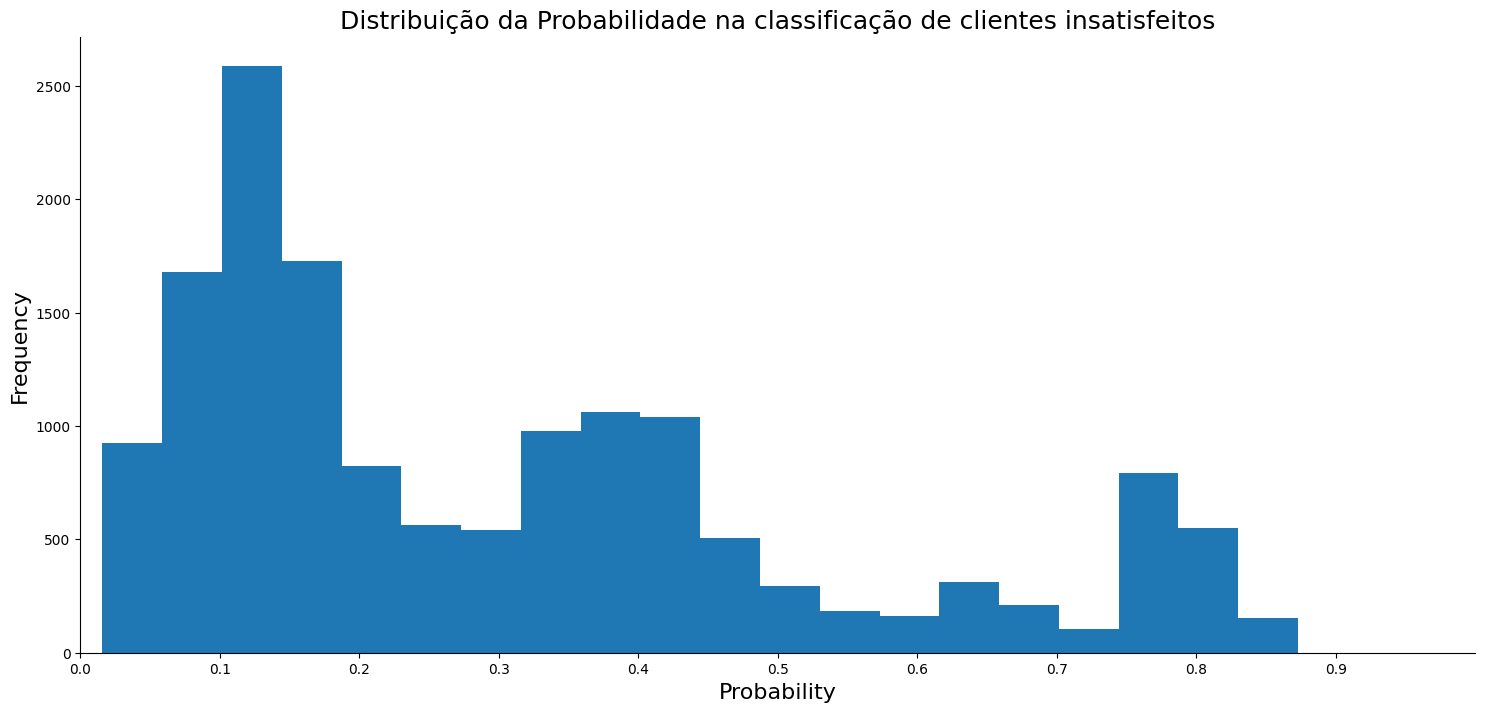

In [9]:
fig, ax = plt.subplots(figsize = (18, 8))
ax.hist(rf_optimized.predict_proba(X_test)[:,1], bins = 20);
ax.set_xlim(0, 1);
plt.xticks(np.arange(0, 1, 0.1))
plt.title('Distribuição da Probabilidade na classificação de clientes insatisfeitos', fontsize=18);
plt.ylabel('Frequency', fontsize=16);
plt.xlabel('Probability', fontsize=16);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Conforme o gráfico acima, a probabilidades tem maior ocorrência até 0,8. Vamos testar de uma outra maneira. Agora utilizando o predict_proba para as bases de treino e teste.

In [10]:
y_pred_train = rf_optimized.predict(X_train)
y_pred_proba_train = rf_optimized.predict_proba(X_train)[:,1]
y_pred = rf_optimized.predict(X_test)
y_pred_proba = rf_optimized.predict_proba(X_test)[:,1]

A ideia é identificar a relação de precisão e sensibilidade para analisar o limiar (threshold) de probabilidade.

In [11]:
pr, recall, thr = precision_recall_curve(y_test, y_pred_proba)
pr_train, recall_train, thr_train = precision_recall_curve(y_train, y_pred_proba_train)

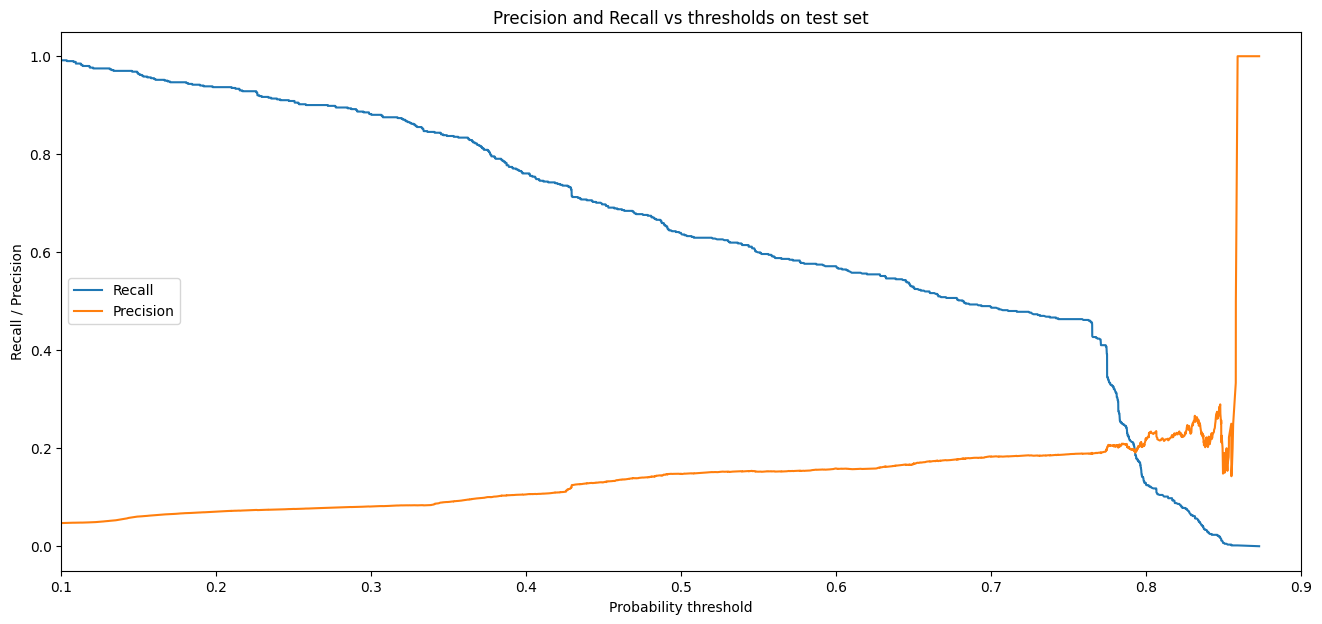

In [12]:
_ = plt.figure(figsize=(16,7))
_ = plt.plot(thr, recall[1:],label='Recall')
_ = plt.plot(thr, pr[1:],label='Precision')
_ = plt.xlabel('Probability threshold')
_ = plt.ylabel('Recall / Precision')
_ = plt.title('Precision and Recall vs thresholds on test set')
_ = plt.legend()
_ = plt.xlim([0.1,0.9])
plt.show()

A intersecção parece estar bem próxima do gráfico de distribuição anterior (0,8).

Como a ideia é dar uma nota de 1 a 5 mas pensando em maximizar o lucro, utilizo uma função criada pelo Caio Martins (https://github.com/CaioMar/certificao_data_masters/blob/master/Certificacao%20Data%20Masters.ipynb) que retorna o lucro conforme o y de teste e a previsão.

In [17]:
def max_profit_score(y_true, y_pred):
    """
    Função que avalia o modelo computando o lucro esperado
    da ação de retenção dos clientes insatisfeitos.
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    FP = conf_matrix[0][1] # Falsos positivos
    TP = conf_matrix[1][1] # Verdadeiros positivos
    
    lucro = 90*TP - 10*FP # lucro da acao de retencao (os 
                          # verdadeiros e falsos negativos
                          # não contribuem em
                          # nada no lucro)
#     print(FP, TP)
    return lucro

Vamos testar o intervalo de 0.2 a 0.9 para avaliar o valor do lucro na base de treino e teste. Percebe-se um certo overfitting, mas seguimos com o estudo.

29433 2362
29208 2361
29000 2361
28791 2360
28583 2359
28408 2358
28215 2355
28032 2355
27871 2353
27678 2352
27481 2352
27290 2352
27112 2351
26962 2351
26816 2350
26693 2350
26515 2349
26358 2347
26194 2345
26053 2344
25913 2343
25754 2341
25640 2341
25510 2341
25375 2340
25259 2338
25132 2336
24997 2335
24887 2335
24778 2333
24656 2333
24537 2332
24433 2332
24304 2331
24115 2331
23966 2330
23833 2329
23727 2329
23579 2327
23456 2326
23313 2325
23194 2323
23066 2323
22925 2323
22799 2319
22648 2318
22507 2317
22363 2317
22203 2317
22055 2313
21612 2310
20970 2304
20334 2296
20074 2295
19817 2293
19517 2287
19252 2282
18957 2278
18550 2271
18192 2265
17852 2260
17575 2253
17227 2245
16918 2232
16546 2221
16231 2212
15982 2207
15742 2201
15563 2198
15406 2187
15250 2183
15107 2176
14973 2167
14841 2161
14712 2154
14571 2151
14423 2145
14268 2134
14113 2124
13921 2118
13773 2113
13053 2104
11589 2066
11484 2062
11392 2054
11232 2046
11141 2043
11040 2033
10908 2025
10792 2018
10517 2009

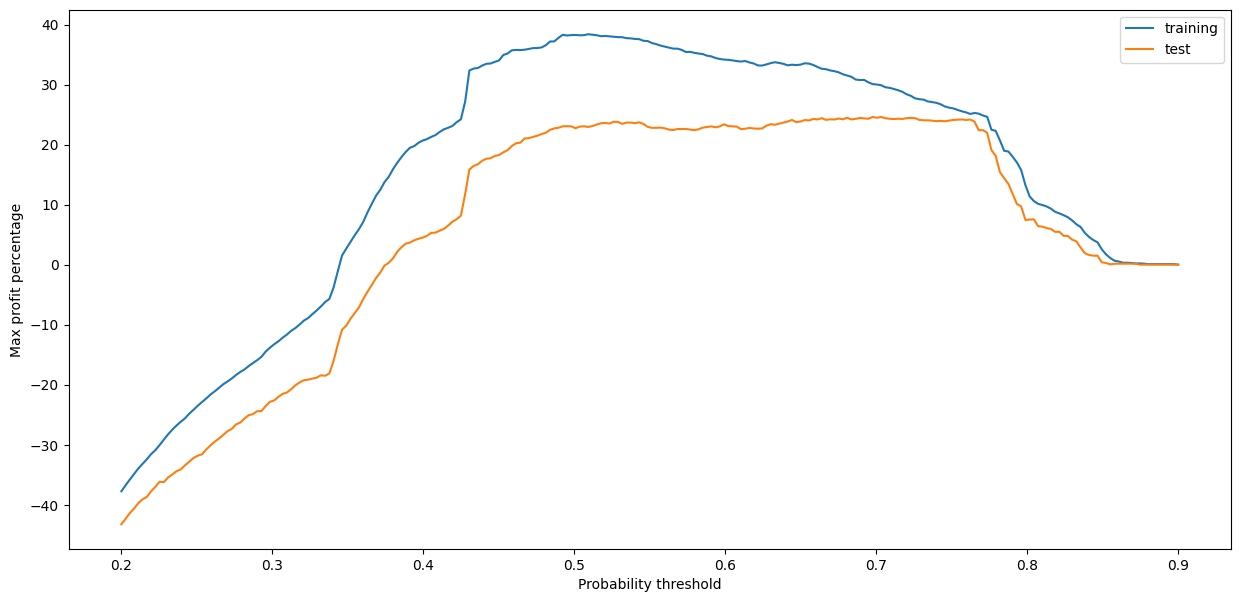

In [18]:
thresholds = np.linspace(0.2,0.9,250)
total_profit_percentage = [max_profit_score(y_train, (y_pred_proba_train > i)*1)/(y_train.sum()*90)*100 for i in thresholds]
total_profit_percentage_test = [max_profit_score(y_test, (y_pred_proba > i)*1)/(y_test.sum()*90)*100 for i in thresholds]
_ = plt.figure(figsize=(15,7))
_ = plt.plot(thresholds, total_profit_percentage, label='training')
_ = plt.plot(thresholds, total_profit_percentage_test, label='test')
_ = plt.ylabel('Max profit percentage')
_ = plt.xlabel('Probability threshold')
_ = plt.legend()

In [19]:

threshold_for_max_profit = thresholds[np.argmax(total_profit_percentage)]
print(threshold_for_max_profit)


0.5092369477911647


In [20]:
print(classification_report(y_test, (y_pred_proba > threshold_for_max_profit)*1) )

              precision    recall  f1-score   support

           0       0.98      0.85      0.91     14602
           1       0.15      0.63      0.24       602

    accuracy                           0.84     15204
   macro avg       0.57      0.74      0.58     15204
weighted avg       0.95      0.84      0.89     15204



Agora vamos dividir o valor predito conforme o limiar (0,51) para termos as 5 notas.

In [21]:
notas = pd.cut(y_pred_proba, bins=list(np.linspace(0,threshold_for_max_profit,5))+[1.0], labels=[5,4,3,2,1])

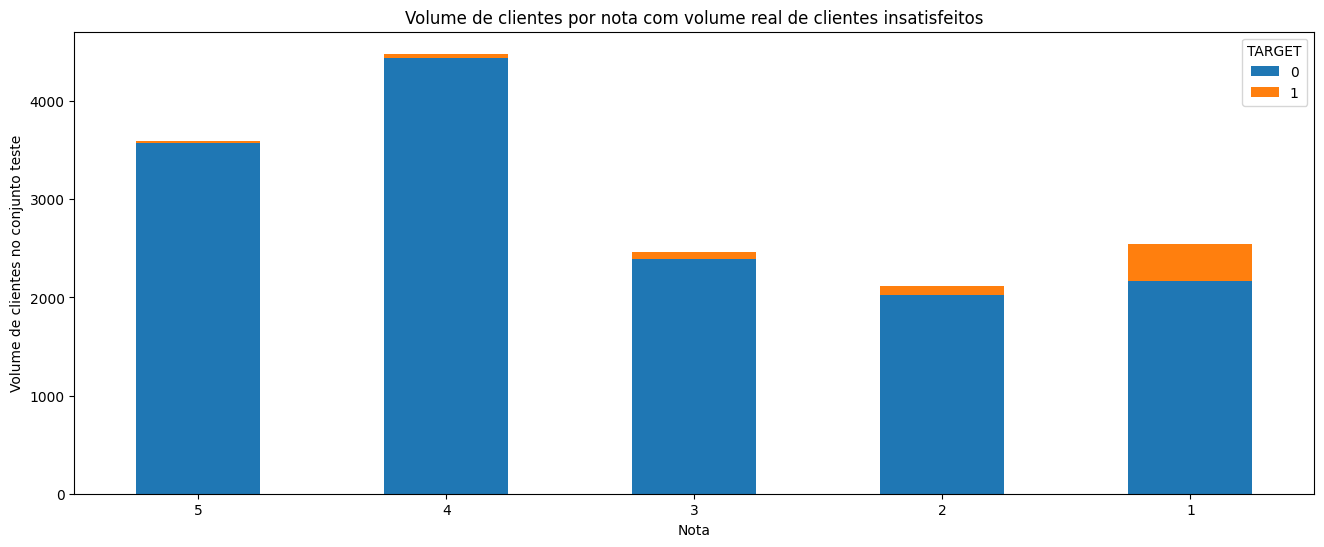

In [22]:
_ = pd.concat((pd.Series(notas, name='notas'), y_test.reset_index(drop=True)), axis=1, ignore_index=False).\
    groupby(['TARGET','notas']).size().unstack('TARGET').plot.bar(stacked=True,figsize = (16,6))
_ = plt.xticks(rotation=0)
_ = plt.ylabel('Volume de clientes no conjunto teste')
_ = plt.xlabel('Nota')
_ = plt.title('Volume de clientes por nota com volume real de clientes insatisfeitos')

No gráfico, vemos uma concentração maior de clientes insatisfeitos (conforme solicitado), o que auxilia na ação de retenção.

In [23]:
print("Lucro total das notas 1 no conjunto de treinamento: R$ "+str(max_profit_score(y_test, (notas == 1)*1)))
print("Representando "+str(round(max_profit_score(y_test, (notas == 1)*1)/(y_test.sum()*90)*100,1))+ "% do máximo lucro possível no conjunto de teste.")


2168 379
Lucro total das notas 1 no conjunto de treinamento: R$ 12430
2168 379
Representando 22.9% do máximo lucro possível no conjunto de teste.


Então, chegamos em um valor de quase 23% do lucro total que podíamos adquirir. Vale ressaltar que um valor maior que o da questão anterior (11930).

Próximos passos de testes:
   - Evoluir na precisão da nota 1 para termos uma concentração maior de clientes insatisfeitos no 1º quesito e conseguirmos realizar as ações de retenção.